# Credit Card Fraud Detection Dataset 
## XGBOOST

Questo progetto si concentra sull'analisi e la modellizzazione dei dati, relativi alle transazioni delle carte di credito per l'inviduazione di movomenti fraudolenti. 
Il progetto include i seguenti passaggi:

  - Esplorazione dei Dati: Analisi iniziale per comprendere la struttura del dataset, inclusi tipi di dati, statistiche descrittive e verifica di eventuali        valori mancanti.

  - Visualizzazione dei Dati: Creazione di grafici per visualizzare la distribuzione delle variabili, come istogrammi, boxplot e heatmap di correlazione.

  - Pulizia dei Dati: Rimozione di colonne non necessarie e gestione di eventuali anomalie nei dati.

  -  Scaling delle Caratteristiche: Normalizzazione delle variabili numeriche per migliorare le prestazioni dei modelli di machine learning.

  - Bilanciamento del dataset

   - Modellizzazione: Utilizzo dell'algoritmi di classificazione XGBoost.

- Valutazione del Modello: Misurazione delle prestazioni del modello attraverso metriche come accuratezza, precisione e richiamo, oltre a visualizzazioni come la matrice di confusione

In [1]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, f1_score, auc, recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import kagglehub

In [3]:
# Download latest version
path = kagglehub.dataset_download("bhadramohit/credit-card-fraud-detection")

print("Path to dataset files:", path)

Path to dataset files: /home/linux/.cache/kagglehub/datasets/bhadramohit/credit-card-fraud-detection/versions/1


In [8]:
df = pd.read_csv("/home/linux/.cache/kagglehub/datasets/bhadramohit/credit-card-fraud-detection/versions/1/credit_card_fraud_dataset.csv", encoding='utf-8')

## 

## DATA VISUALIZATION

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


In [10]:
df

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0
...,...,...,...,...,...,...,...
99995,99996,2024-06-07 00:57:36.027591,1057.29,289,refund,San Antonio,0
99996,99997,2023-10-22 23:12:36.027594,297.25,745,refund,San Antonio,0
99997,99998,2024-05-31 19:27:36.027597,3448.56,690,purchase,San Antonio,0
99998,99999,2024-10-18 09:43:36.027601,3750.79,644,purchase,Philadelphia,0


In [16]:
df.describe()

,Amount,MerchantID,IsFraud
count,100000.000000,100000.000000,100000.000000
mean,2497.092666,501.676070,0.010000
std,1442.415999,288.715868,0.099499
min,1.050000,1.000000,0.000000
25%,1247.955000,252.000000,0.000000
50%,2496.500000,503.000000,0.000000
75%,3743.592500,753.000000,0.000000
max,4999.770000,1000.000000,1.000000


In [12]:
df.isnull().sum()

TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [13]:
print(df.dtypes)


TransactionID        int64
TransactionDate     object
Amount             float64
MerchantID           int64
TransactionType     object
Location            object
IsFraud              int64
dtype: object


In [14]:
# Imposta la prima colonna come indice
df.set_index(df.columns[0], inplace=True)

# Visualizza il DataFrame aggiornato
print(df)

                          TransactionDate   Amount  MerchantID  \
TransactionID                                                    
1              2024-04-03 14:15:35.462794  4189.27         688   
2              2024-03-19 13:20:35.462824  2659.71         109   
3              2024-01-08 10:08:35.462834   784.00         394   
4              2024-04-13 23:50:35.462850  3514.40         944   
5              2024-07-12 18:51:35.462858   369.07         475   
...                                   ...      ...         ...   
99996          2024-06-07 00:57:36.027591  1057.29         289   
99997          2023-10-22 23:12:36.027594   297.25         745   
99998          2024-05-31 19:27:36.027597  3448.56         690   
99999          2024-10-18 09:43:36.027601  3750.79         644   
100000         2024-03-05 19:41:36.027606  1596.79         675   

              TransactionType      Location  IsFraud  
TransactionID                                         
1                      refund  

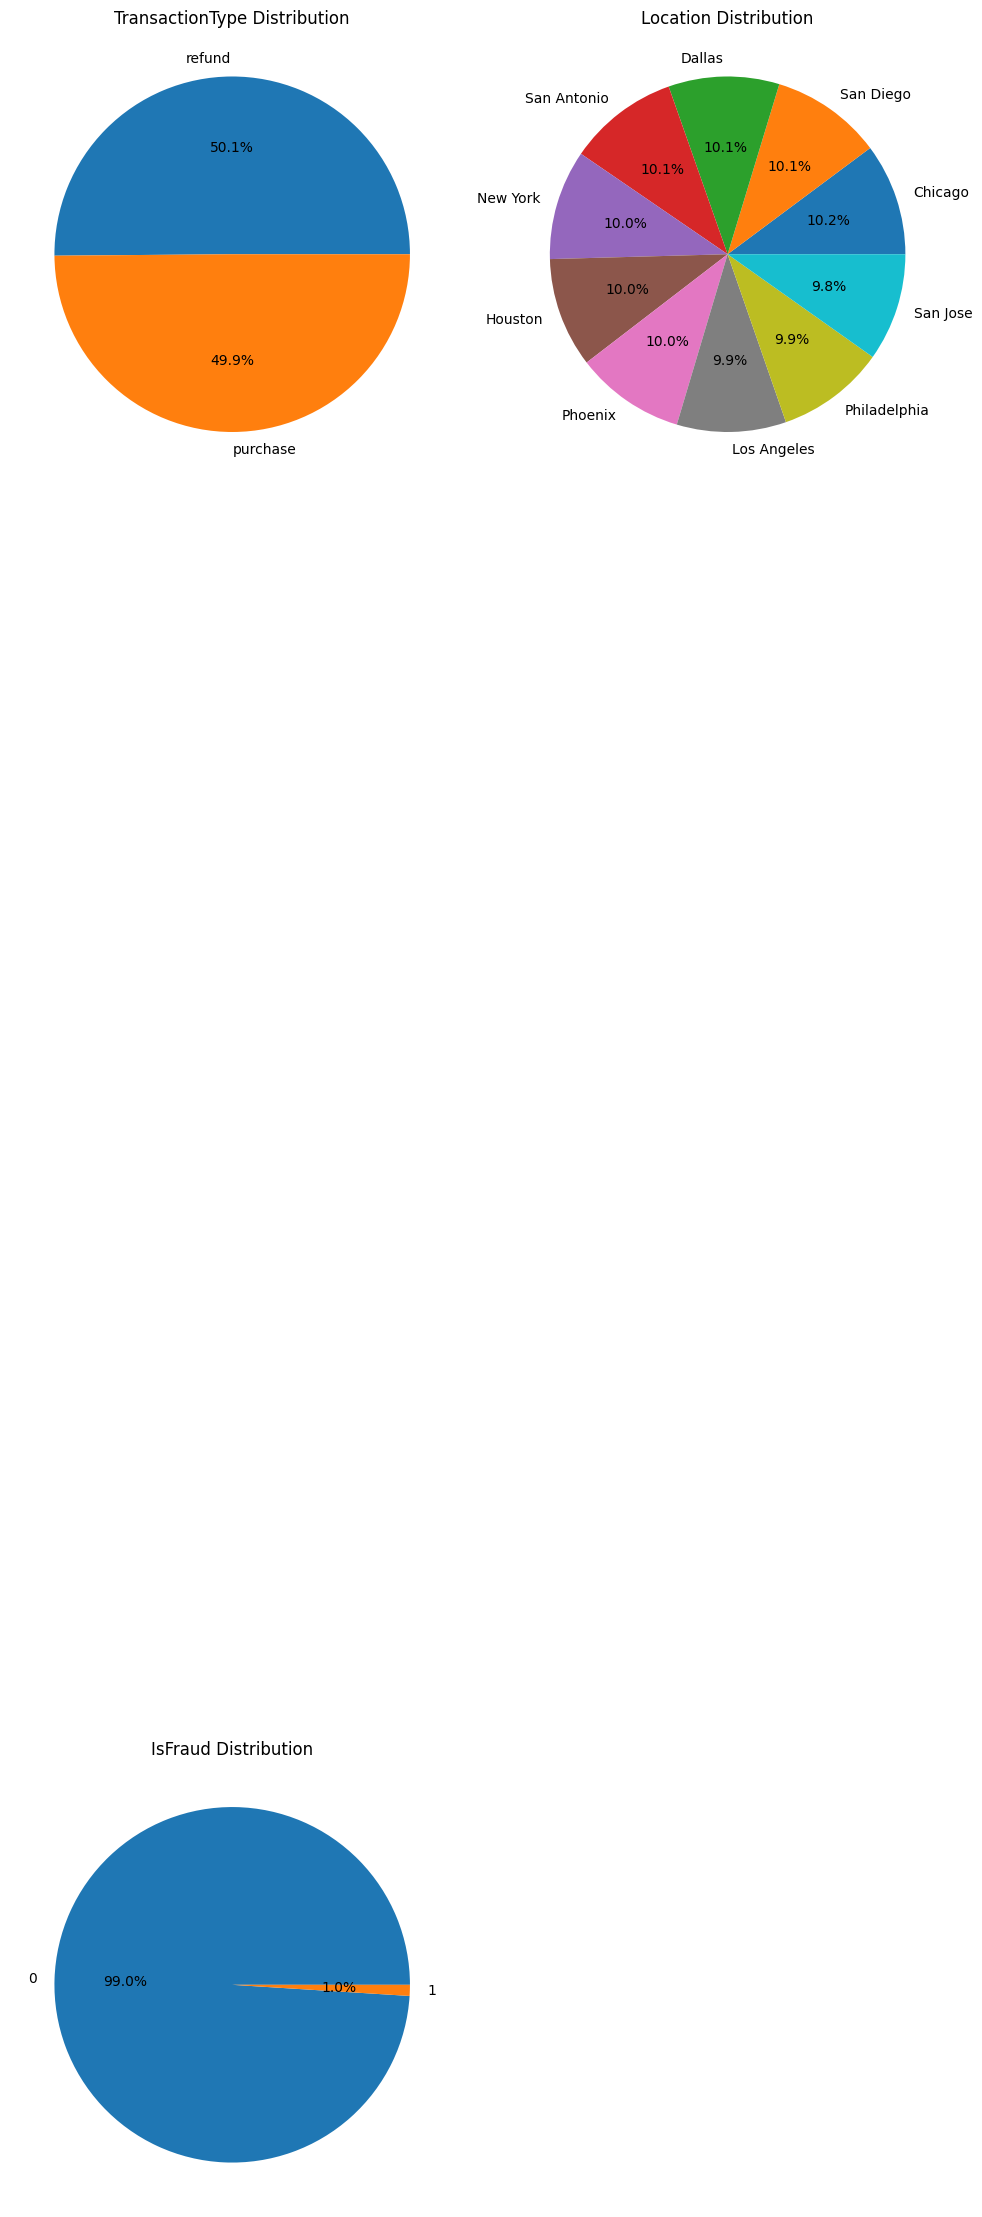

In [15]:
# Definizione delle colonne discrete
columns_d = [  'TransactionType', 'Location', 'IsFraud'
    
]

# Creazione della figura e degli assi con 2 colonne
fig, axs = plt.subplots(nrows=len(columns_d) // 2 + len(columns_d) % 2, ncols=2, figsize=(10, 40))

# Flatten degli assi per facilitarne l'iterazione
axs = axs.flatten()

for i, col in enumerate(columns_d):
    counts = df[col].value_counts()
    axs[i].pie(counts, labels=counts.index.astype(str), autopct='%1.1f%%')
    axs[i].set_title(f'{col} Distribution')

# Rimozione degli assi non utilizzati (nel caso di un numero dispari di colonne)
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [11]:
# Mappare i valori di TransactionType
transaction_type_mapping = {'refund': 0, 'purchase': 1}

# Applicare la mappatura al DataFrame
df['TransactionType'] = df['TransactionType'].map(transaction_type_mapping)


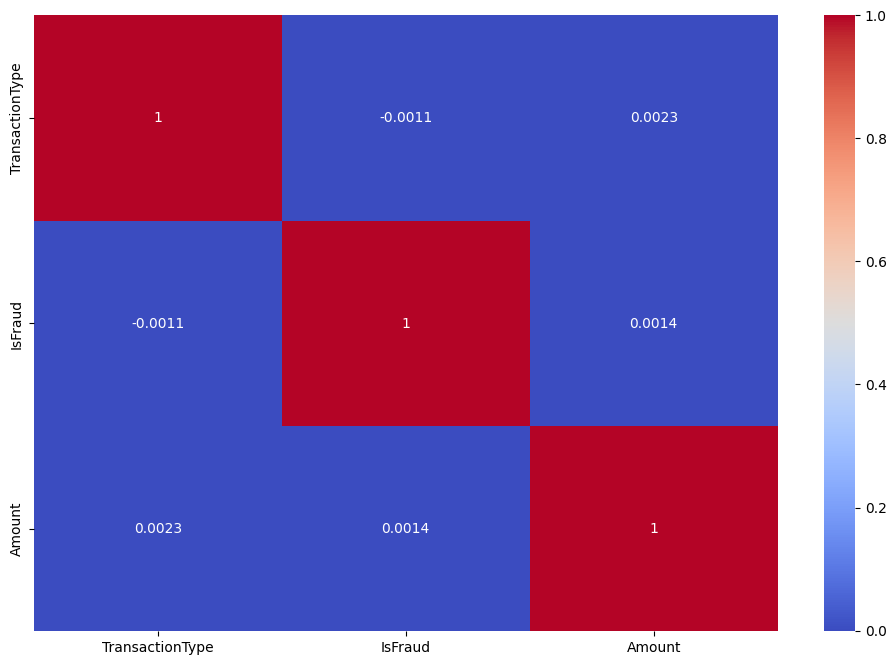

In [12]:
# Calcola la matrice di correlazione
correl_map = [ 'TransactionType', 'IsFraud', 'Amount']
correlation_matrix = df[correl_map].corr()

# Crea una heatmap utilizzando Seaborn
plt.figure(figsize=(12, 8))  # Dimensione del grafico
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 

In [13]:
# Converti la colonna 'TransactionDate' in formato datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Estrai caratteristiche dalla data
df['anno'] = df['TransactionDate'].dt.year
df['mese'] = df['TransactionDate'].dt.month
df['giorno'] = df['TransactionDate'].dt.day
df['ora'] = df['TransactionDate'].dt.hour
df['minuto'] = df['TransactionDate'].dt.minute
df['secondo'] = df['TransactionDate'].dt.second

# Rimuovi la colonna originale 'TransactionDate' se non è più necessaria
df = df.drop(columns=['TransactionDate'])


In [14]:
# Creare un dizionario per mappare le location a valori numerici
location_mapping = {location: idx for idx, location in enumerate(df['Location'].unique())}

# Applicare la mappatura al DataFrame
df['Location'] = df['Location'].map(location_mapping)




In [15]:
# Sposta 'IsFraud' come ultima colonna
df = df[[col for col in df.columns if col != 'IsFraud'] + ['IsFraud']]

# Visualizza il DataFrame aggiornato
print(df.head())

                Amount  MerchantID  TransactionType  Location  anno  mese  \
TransactionID                                                               
1              4189.27         688                0         0  2024     4   
2              2659.71         109                0         1  2024     3   
3               784.00         394                1         2  2024     1   
4              3514.40         944                1         3  2024     4   
5               369.07         475                1         4  2024     7   

               giorno  ora  minuto  secondo  IsFraud  
TransactionID                                         
1                   3   14      15       35        0  
2                  19   13      20       35        0  
3                   8   10       8       35        0  
4                  13   23      50       35        0  
5                  12   18      51       35        0  


In [16]:
# Mostrare il DataFrame aggiornato

print(df)

                Amount  MerchantID  TransactionType  Location  anno  mese  \
TransactionID                                                               
1              4189.27         688                0         0  2024     4   
2              2659.71         109                0         1  2024     3   
3               784.00         394                1         2  2024     1   
4              3514.40         944                1         3  2024     4   
5               369.07         475                1         4  2024     7   
...                ...         ...              ...       ...   ...   ...   
99996          1057.29         289                0         0  2024     6   
99997           297.25         745                0         0  2023    10   
99998          3448.56         690                1         0  2024     5   
99999          3750.79         644                1         3  2024    10   
100000         1596.79         675                0         8  2024     3   

In [28]:
print(df.dtypes)


Amount             float64
TransactionType      int64
Location             int64
anno                 int32
mese                 int32
giorno               int32
ora                  int32
minuto               int32
secondo              int32
IsFraud              int64
dtype: object


In [29]:
x, y = df.iloc[:,:-1], df.iloc[:,-1]
print(y)

TransactionID
1         0
2         0
3         0
4         0
5         0
         ..
99996     0
99997     0
99998     0
99999     0
100000    0
Name: IsFraud, Length: 100000, dtype: int64


## Bilanciamento dataset

In [30]:

# Inizializza SMOTE
smote = SMOTE(random_state=42)

# Esegui SMOTE
x_resampled, y_resampled = smote.fit_resample(x, y)

# Crea un nuovo DataFrame
df_balanced = pd.DataFrame(x_resampled, columns=x.columns)
df_balanced['IsFraud'] = y_resampled


In [31]:
x, y = df_balanced.iloc[:,:-1], df_balanced.iloc[:,-1]
print(y)

0         0
1         0
2         0
3         0
4         0
         ..
197995    1
197996    1
197997    1
197998    1
197999    1
Name: IsFraud, Length: 198000, dtype: int64


In [32]:
print(df_balanced['IsFraud'].value_counts())


IsFraud
0    99000
1    99000
Name: count, dtype: int64


In [33]:
df_balanced


,Amount,TransactionType,Location,anno,mese,giorno,ora,minuto,secondo,IsFraud
0,4189.270000,0,0,2024,4,3,14,15,35,0
1,2659.710000,0,1,2024,3,19,13,20,35,0
2,784.000000,1,2,2024,1,8,10,8,35,0
3,3514.400000,1,3,2024,4,13,23,50,35,0
4,369.070000,1,4,2024,7,12,18,51,35,0
...,...,...,...,...,...,...,...,...,...,...
197995,4531.961263,0,4,2023,5,19,0,25,35,1
197996,2277.873700,0,7,2024,5,17,5,25,35,1
197997,3730.717683,0,5,2024,8,3,14,54,35,1
197998,4290.225020,1,2,2024,5,27,16,23,35,1


## MODELING 

In [34]:
target_column = 'IsFraud'

In [35]:
print(x.shape)  # Dimensioni del set di feature
print(y.shape)


(198000, 9)
(198000,)


In [36]:
data_dmatrix = xgb.DMatrix(data=x, label=y)

In [37]:
# Suddivisione del dataset in train-val e test
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Suddivisione del train-val in train e validation

x_train, x_valid, y_train, y_valid = train_test_split(x_trainval, y_trainval, test_size=0.25, random_state=42)

# Inizializzazione del modello XGBoost
xg_clf = XGBClassifier(objective='binary:logistic', )

# Definizione del parametro per la GridSearchCV
param_grid = {
    'colsample_bytree': [0.2, 0.3, 0.4],
    'n_estimators': [50, 75, 100, 150, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'alpha': [5, 10, 20],
}

# Ricerca degli iperparametri tramite GridSearchCV sui dati di train 
grid_search = GridSearchCV(xg_clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)  # Fit sulla parte di training

# Miglior modello
best_xg_clf = grid_search.best_estimator_

# Predizione sul test set
y_pred = best_xg_clf.predict(x_test)

In [38]:
print(f"Best parameters for Decision Tree:", best_xg_clf)


Best parameters for Decision Tree: XGBClassifier(alpha=5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)





## RISULTATI

In [39]:

# Valutare le prestazioni del modello sul test set
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Report di classificazione
print(classification_report(y_test, y_pred))


Precision: 0.9144836750189825
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     19777
           1       0.91      0.97      0.94     19823

    accuracy                           0.94     39600
   macro avg       0.94      0.94      0.94     39600
weighted avg       0.94      0.94      0.94     39600



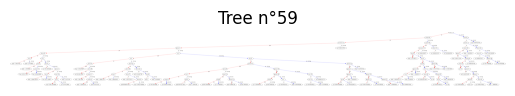

In [40]:
# visualizzazione di uno degli alberi  decisionali utilizzati dal modello
# addestrato

idx = np.random.randint(0, 100)
xgb.plot_tree(best_xg_clf, num_trees=1)
plt.rcParams['figure.figsize'] = [30, 15]
plt.title('Tree n°' + str(idx))
plt.show()

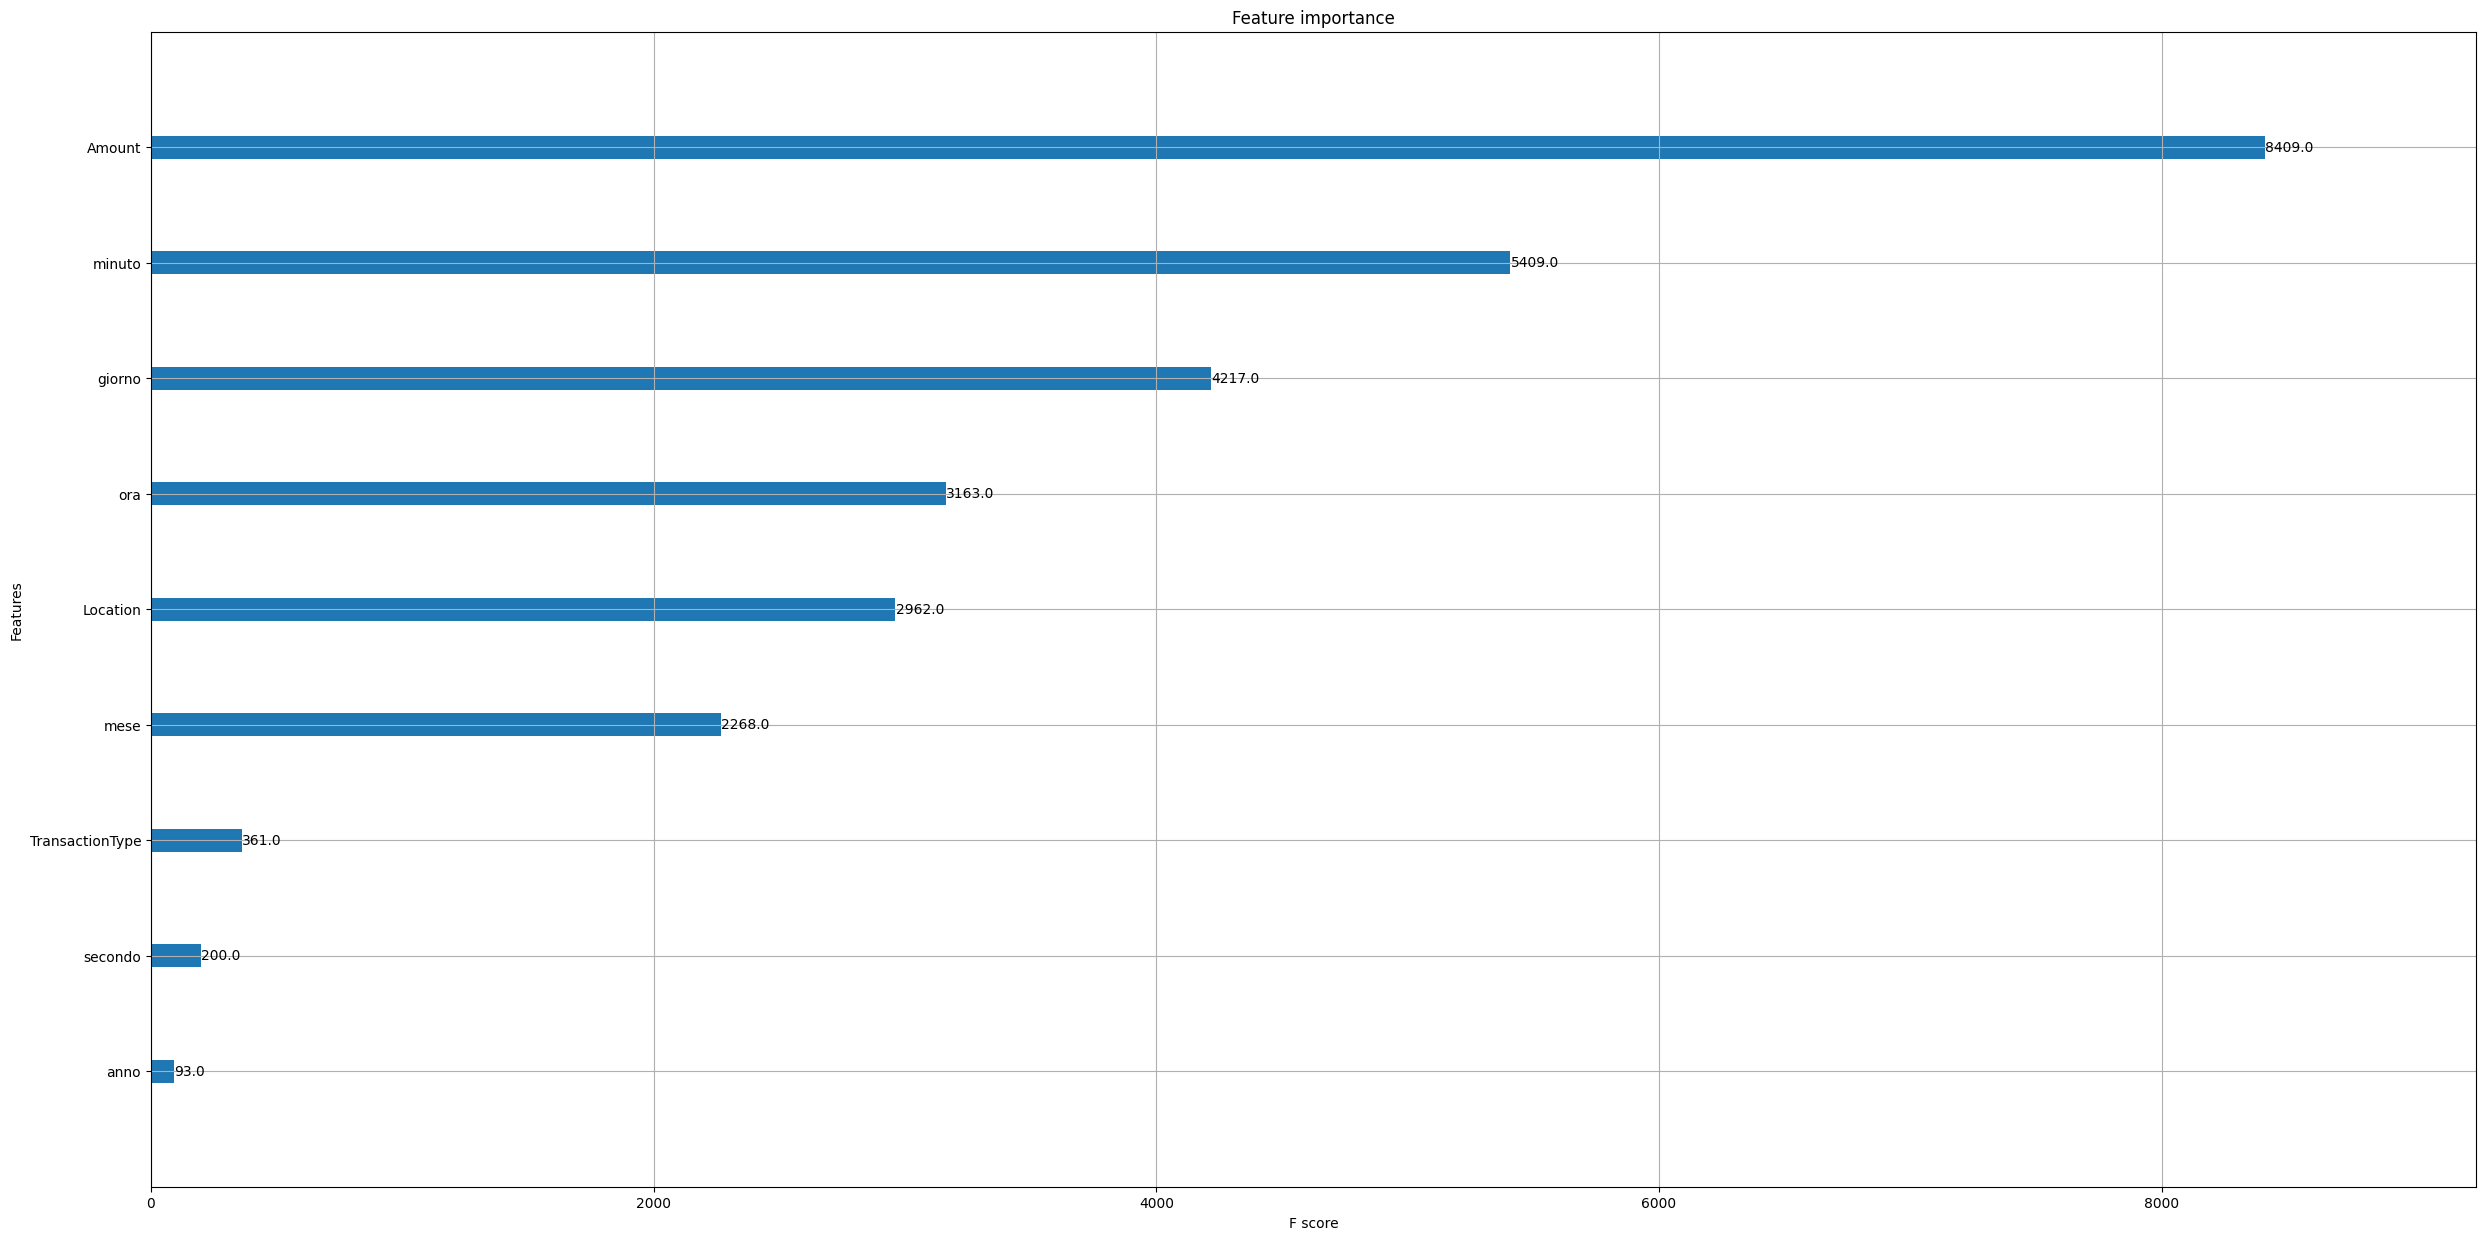

In [41]:
xgb.plot_importance(best_xg_clf)
plt.rcParams['figure.figsize'] = [10, 15]
plt.show()

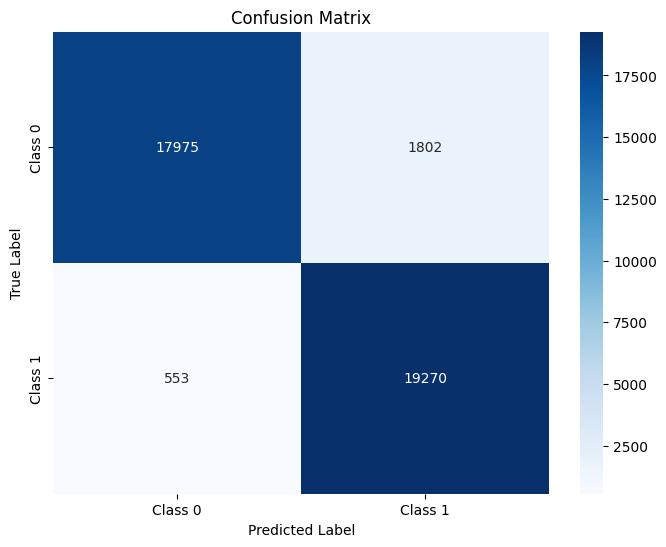

In [42]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

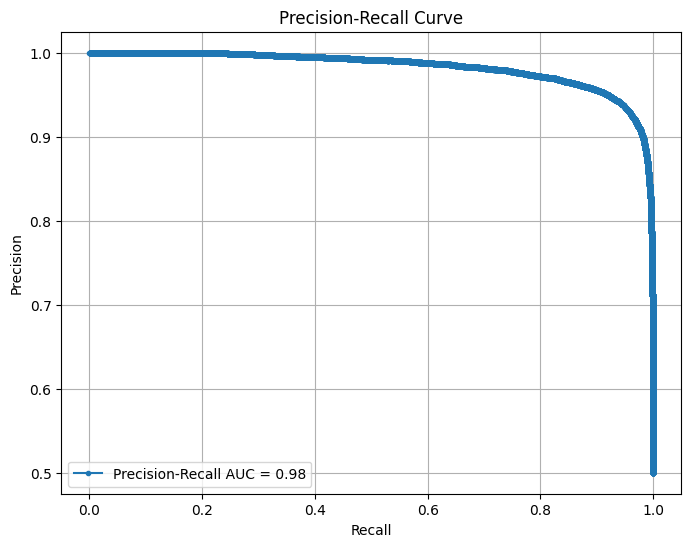

Precision for IsFraud label using XGBoost classifier: [0.50058081 0.50059345 0.50060609 ... 1.         1.         1.        ]
F1 Score for IsFraud label using XGBoost classifier: 0.9424134979826385


In [43]:

 #Calcola le probabilità predette (predict_proba)
y_pred_proba = best_xg_clf.predict_proba(x_test)  # X_test è il tuo set di test

# Calcola le etichette predette (predict)
y_pred = best_xg_clf.predict(x_test)

# Controlla se il problema è di classificazione binaria
if len(best_xg_clf.classes_) == 2:
# Calcola precisione, richiamo e soglie usando il modello predittivo
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])
    
    # Calcolo F1 Score
    f1 = f1_score(y_test, y_pred)

    # Calcolo AUC per la curva Precision-Recall
    pr_auc = auc(recall, precision)

    # Plot della curva Precision-Recall
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label=f'Precision-Recall AUC = {pr_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Stampa i valori di precisione e F1 score
    print(f"Precision for {target_column} label using XGBoost classifier:", precision)
    print(f"F1 Score for {target_column} label using XGBoost classifier:", f1)

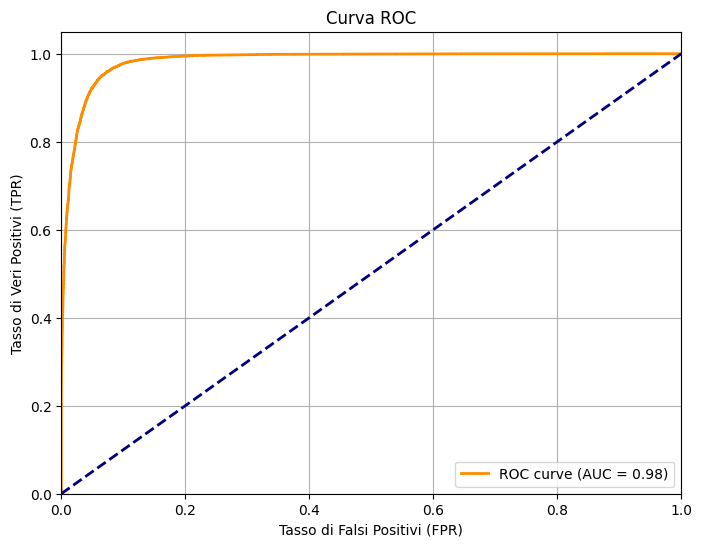

In [44]:

# Calcola le probabilità predette (predict_proba)
y_pred_proba = best_xg_clf.predict_proba(x_test)  # X_test è il set di test

# Calcola la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Calcola l'Area sotto la curva (AUC)
roc_auc = auc(fpr, tpr)

# Plot della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasso di Falsi Positivi (FPR)')
plt.ylabel('Tasso di Veri Positivi (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [45]:
import joblib

model = XGBClassifier()
model.fit(x_train, y_train)  

# Salva  modello
joblib.dump(model, 'credit_card.pkl')


['credit_card.pkl']